In [1]:
import lbg_forecast.priors_gp_massfunc as gpmf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc


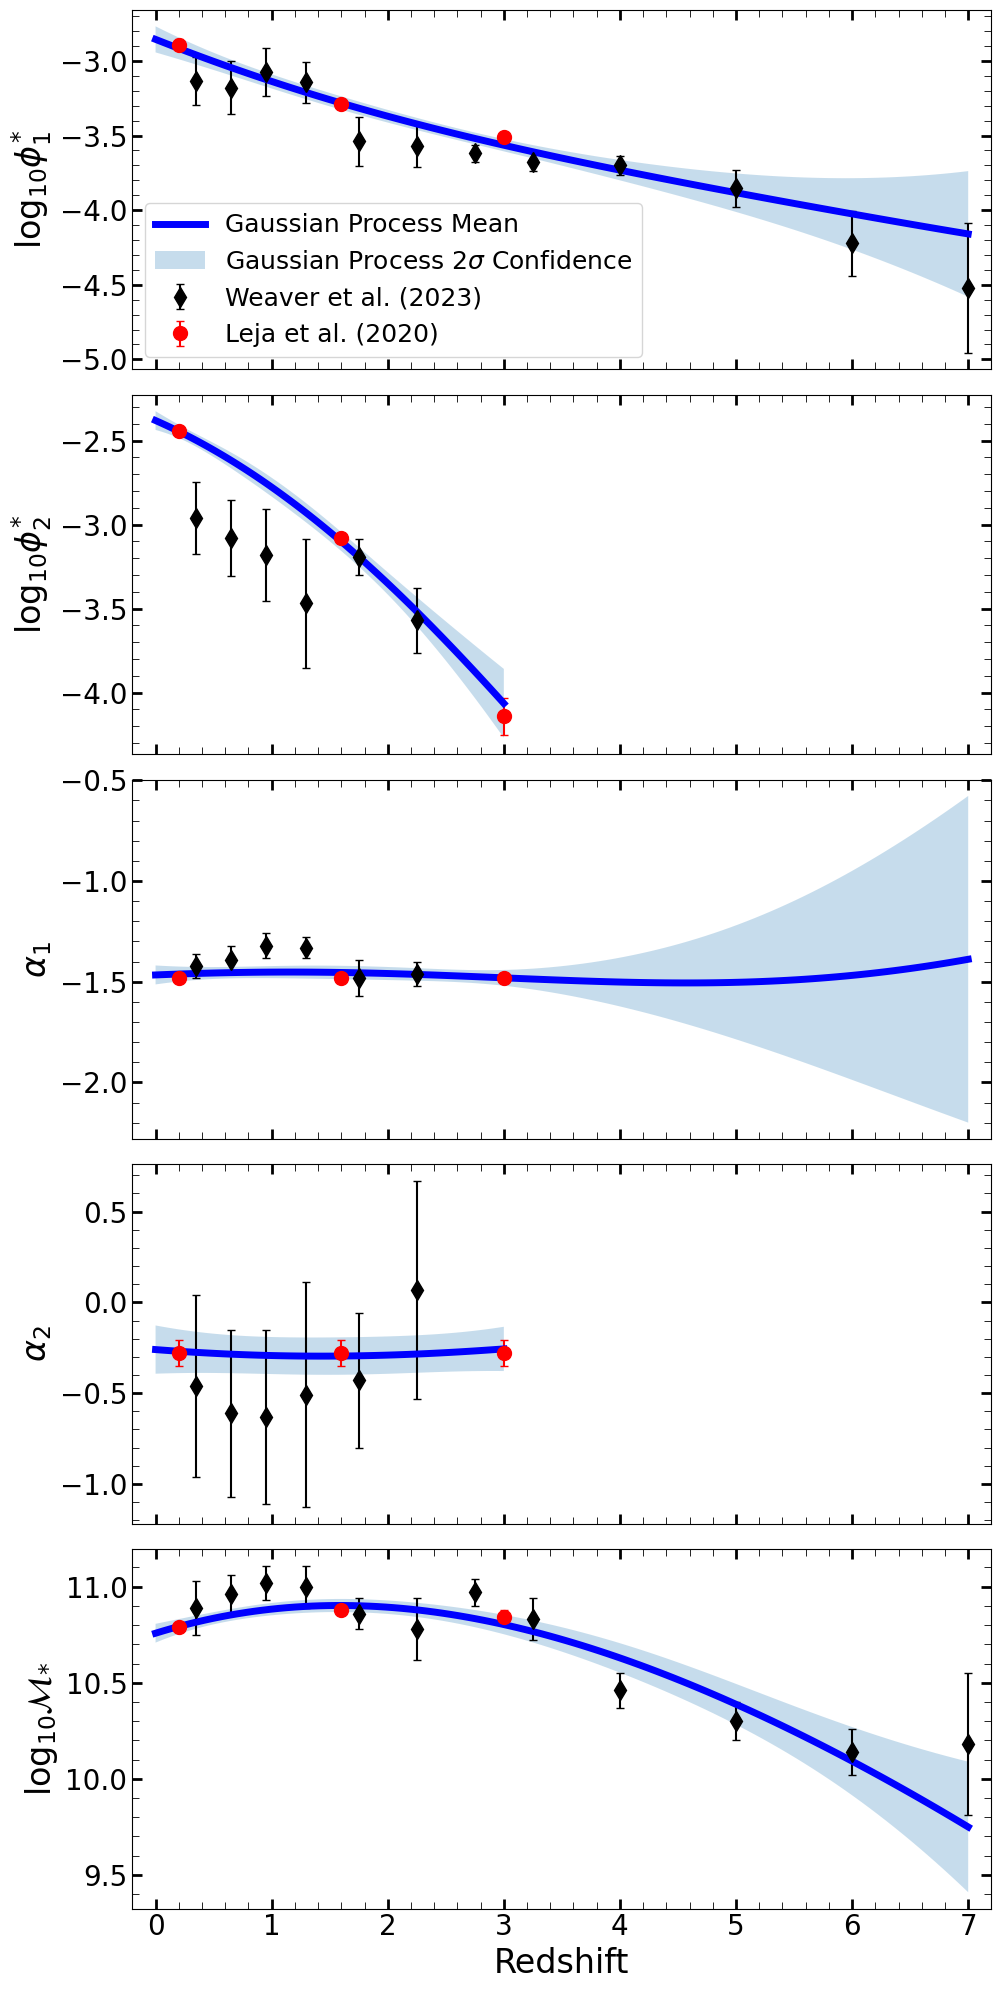

In [2]:
mass_function_prior = gpmf.MassFunctionPrior()

mass_function_prior.plot_confidence()

In [3]:
#mass_function_prior.mass_function(1.0, 8.0, sparams)

def n(z, logm, sparams):

    dzbin = 0.25
    dlogmbin = 0.25
    logmbins = np.arange(7, 13+dlogmbin, dlogmbin)
    zbins = np.arange(0.0, 7.0+dzbin, dzbin)

    binned_z = zbins[np.digitize(z, zbins)-1]
    binned_logm = logmbins[np.digitize(logm, logmbins)-1]

    dlogm = 0.025
    dz = 0.025
    logmgrid = np.arange(binned_logm, binned_logm+dlogmbin, dlogm)
    zgrid = np.arange(binned_z, binned_z+dzbin, dz)

    return mass_function_prior.number_of_galaxies(zgrid, logmgrid, sparams)

def n_marg(sparams):

    zs = np.arange(0.5, 7.0, 0.25)
    logms = np.arange(7.5, 13, 0.25)

    tot_n = []
    for z in zs:
        tot_n_z = 0
        for logm in logms:
            tot_n_z+=n(z, logm, sparams)
        tot_n.append(tot_n_z)

    plt.plot(zs, tot_n/np.trapz(tot_n, zs))

    return tot_n/np.trapz(tot_n, zs)

def logm_marg(sparams):

    zs = np.arange(0.5, 7.0, 0.25)
    logms = np.arange(7.5, 13, 0.25)

    tot_n = []
    for logm in logms:
        tot_n_logm = 0
        for z in zs:
            tot_n_logm+=n(z, logm, sparams)
        tot_n.append(tot_n_logm)

    plt.plot(logms, tot_n/np.trapz(tot_n, logms))

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


array([0.28783161, 0.37137543, 0.40805636, 0.40889653, 0.38750976,
       0.35406333, 0.31501237, 0.27542215, 0.23764936, 0.20247984,
       0.16998072, 0.14221052, 0.11802304, 0.09726696, 0.07953317,
       0.06454986, 0.05206602, 0.04171442, 0.03322015, 0.02630776,
       0.02076167, 0.01631016, 0.01278432, 0.01001118, 0.00782446,
       0.0061093 ])

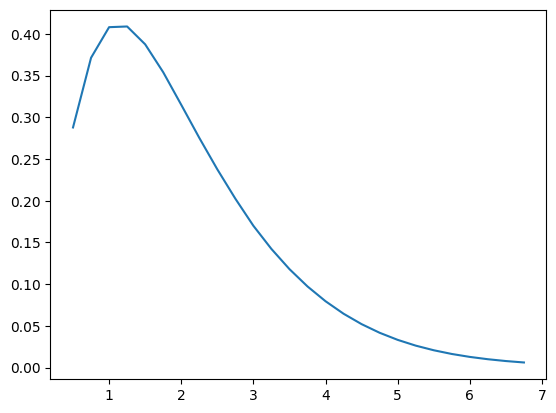

In [4]:
n_marg(mass_function_prior.sample_prior())

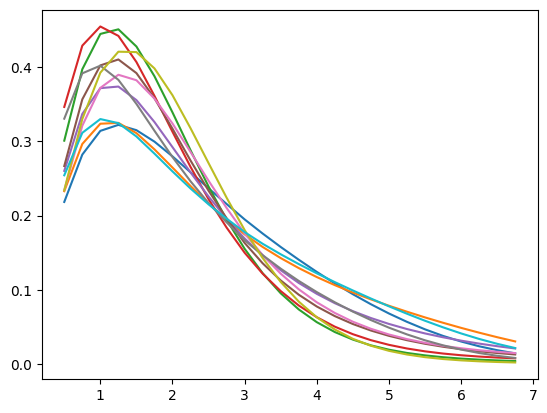

In [5]:
for i in range(10):
    n_marg(mass_function_prior.sample_prior())
   

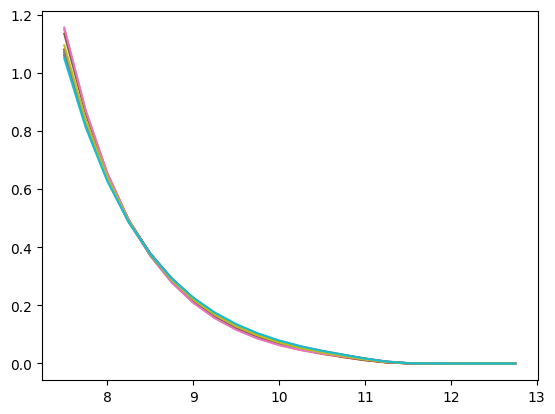

In [6]:
for i in range(10):
    logm_marg(mass_function_prior.sample_prior())

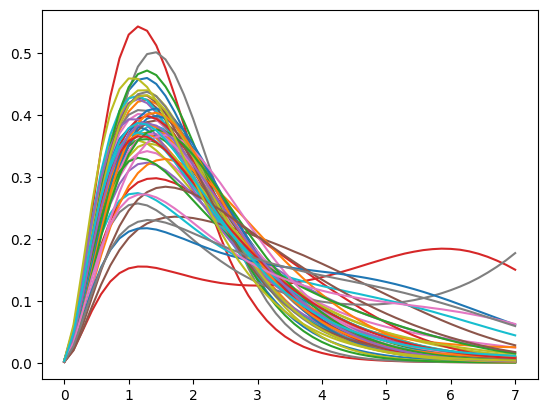

In [7]:
z_grid = np.linspace(0.0, 7.0, 50)
for i in range(50):
    nz = mass_function_prior.calculate_nz_marginal(z_grid, mass_function_prior.sample_prior())
    plt.plot(z_grid, nz/np.trapz(nz, z_grid))

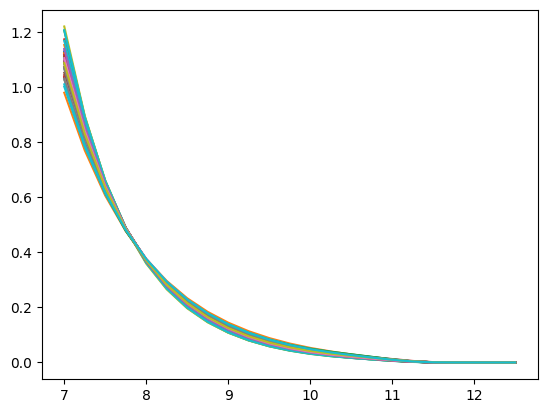

In [8]:
mbins = np.vstack((np.arange(7, 12.75, 0.25), np.arange(7.25, 13, 0.25))).T
for i in range(50):
    nlogm = mass_function_prior.calculate_nlogm_marginal(mbins, mass_function_prior.sample_prior())
    plt.plot(mbins[:, 0], nlogm/np.trapz(nlogm, mbins[:, 0]))

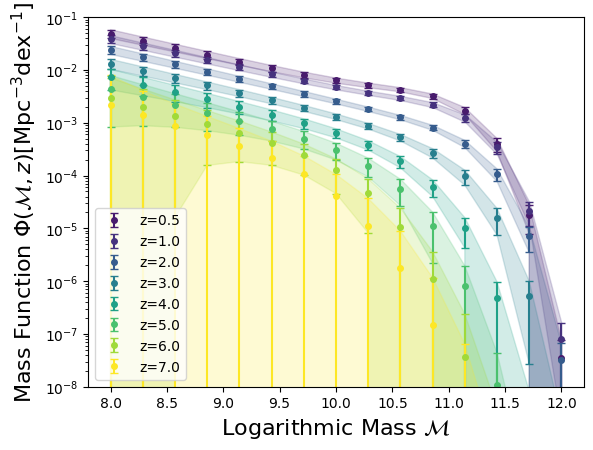

In [9]:
cmap = plt.get_cmap('viridis')
print(cmap)

redshift = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
masses = np.linspace(8, 12, 15)
nsamples = 1000
for z in redshift:
    mfunc_at_z = []
    for n in range(nsamples):
        mfunc = mass_function_prior.mass_function(z, masses, mass_function_prior.sample_prior())
        mfunc_at_z.append(mfunc)

    mfunc_at_z = np.vstack(np.array(mfunc_at_z))
    mfunc_at_z_mean = np.mean(mfunc_at_z, axis=0)
    mfunc_at_z_std = np.std(mfunc_at_z, axis=0)
    #mfunc_at_z_quantile = np.quantile(mfunc_at_z, 0.85, axis=0)
    plt.errorbar(masses, mfunc_at_z_mean, yerr=mfunc_at_z_std, color=cmap(z/7), marker="o", ls=' ', ms=4, label="z="+str(z), capsize=3)
    plt.fill_between(masses, mfunc_at_z_mean-mfunc_at_z_std,  mfunc_at_z_mean+mfunc_at_z_std, color=cmap(z/7), alpha=0.2)
            
plt.ylim(1e-8, 1e-1)
plt.ylabel("Mass Function $\Phi(\mathcal{M}, z) [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$", fontsize=16)
plt.xlabel("Logarithmic Mass $\mathcal{M}$", fontsize=16)
#plt.tick_params('x', labelsize=18, width=2, size=5)
#plt.tick_params('y', labelsize=18, width=2, size=5)
plt.yscale('log')
plt.legend(loc="best")

/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(self.number_of_galaxies(zgrid, logmgrid, sparams))


(505000, 2) 495000
(505000, 2) 495000


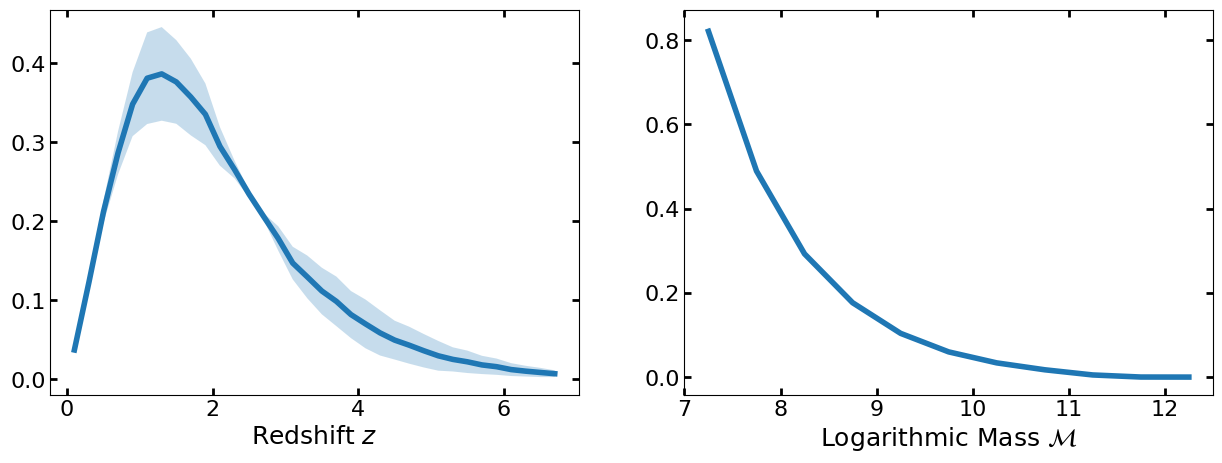

In [11]:
n_prior_samples = 2
zbins = np.arange(0.0, 7.0, 0.2)
mbins = np.arange(7, 13, 0.5)

f, ax = plt.subplots(1, 2, figsize=(15, 5))
zs=[]
ms=[]
for i in range(n_prior_samples):
    zsamples, msamples = mass_function_prior.sample_log_n()
    z_histogram = np.histogram(zsamples, bins=zbins, density=True)
    m_histogram = np.histogram(msamples, bins=mbins, density=True)

    zs.append(z_histogram[0])
    ms.append(m_histogram[0])


zs = np.vstack(np.array(zs))
ms = np.vstack(np.array(ms))
zs_mean = np.mean(zs, axis=0)
zs_std = np.std(zs, axis=0)
ax[0].plot((zbins[:-1]+zbins[1:])/2, zs_mean, lw=4, ms=3)
ax[0].fill_between((zbins[:-1]+zbins[1:])/2, zs_mean-zs_std,  zs_mean+zs_std, alpha=0.25)
ax[0].set_xlabel('Redshift $z$', fontsize=18)
ax[0].tick_params('x', labelsize=16, width=2, size=5, direction='in', top=True)
ax[0].tick_params('y', labelsize=16, width=2, size=5, direction='in', right=True)

ms_mean = np.mean(ms, axis=0)
ms_std = 1*np.std(ms, axis=0)
ax[1].plot((mbins[:-1]+mbins[1:])/2, ms_mean,lw=4)
ax[1].fill_between((mbins[:-1]+mbins[1:])/2, ms_mean-ms_std,  ms_mean+ms_std, alpha=0.25)
ax[1].set_xlabel('Logarithmic Mass $\mathcal{M}$', fontsize=18)
ax[1].tick_params('x', labelsize=16, width=2, size=5, direction='in', top=True)
ax[1].tick_params('y', labelsize=16, width=2, size=5, direction='in', right=True)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)
/Users/fpetri/repos/LBGforecast/lbg_forecast/priors_gp_massfunc.py:180: RuntimeWarning: divide by zero encountered in log
  return np.log(ngalaxies)


(505000, 2) 495000


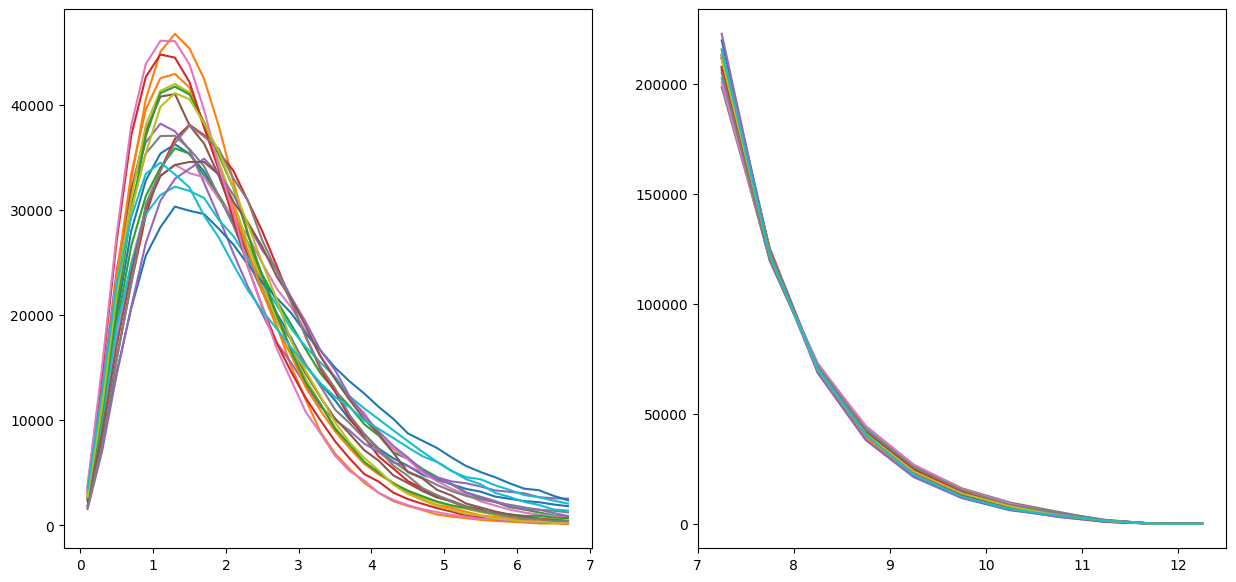

In [7]:
n_prior_samples = 20
zbins = np.arange(0.0, 7.0, 0.2)
mbins = np.arange(7, 13, 0.5)

f, ax = plt.subplots(1, 2, figsize=(15, 7))
zs=[]
ms=[]
for i in range(n_prior_samples):
    zsamples, msamples = mass_function_prior.sample_log_n()
    z_histogram = np.histogram(zsamples, bins=zbins, density=False)
    m_histogram = np.histogram(msamples, bins=mbins, density=False)

    ax[0].plot((zbins[:-1]+zbins[1:])/2, z_histogram[0])
    ax[1].plot((mbins[:-1]+mbins[1:])/2, m_histogram[0])

z_grid = np.linspace(0.0, 7.0, 50)
nsamples=10000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
selected_curves = pr.select_allowed_parameter_curves(z_grid, curves)
pr.plot_mass_function_parameter_curves(z_grid, selected_curves, log_phi_plot=False, alpha=0.1)


z_grid = np.linspace(0.0, 7.0, 50)
nsamples=1000000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
allowed_curves = pr.select_allowed_parameter_curves(z_grid, curves)

sampled_curves = pr.sample_allowed_parameter_curves(z_grid, 1000, allowed_curves)
print(sampled_curves[0].shape, sampled_curves[1].shape, sampled_curves[2].shape, sampled_curves[3].shape, sampled_curves[4].shape)
pr.plot_mass_function_parameter_curves(z_grid, sampled_curves, log_phi_plot=False, alpha=0.1)

prior_data = pr.preload_prior_data(zmax=7.0)

zsamples, logmsamples = pr.sample_redshift_mass_prior(100000, prior_data, prior_bounds=[0.0,7.0,7,13], plotting=True)